# Nonlinear Transport from the Quantum Metric -- Berry Curvature Polarizability 

In [21]:
using LinearAlgebra;
using StaticArrays;
using Makie
using CairoMakie
using Printf


In [22]:
global const νF::Float64 = 1.0; 
global const num_to_xyz::Dict{Int64, String} = Dict(1 => "x", 2 => "y");

In [23]:
# Here, we first define the necessary functions for the Dirac Fermion Hamiltonian, and the velocity matrices 
function eigensystem_dirac_fermion(k::Vector{Float64}, νt::Float64, Δ::Float64, νF::Float64 = νF)
    """
    Returns the eigenvalues and eigenvectors of the Dirac Fermion Hamiltonian
    Parameters: 
        k : momentum (More precisely, the wave-vector)
        νt: Tilt 
        Δ : Gap (Breaks inversion)
    """
    kz = νF * (-im * k[1] - k[2]); kzc = νF * (im * k[1] - k[2])
    eigen([Δ+νt*k[2] kz; kzc -Δ+νt*k[2]])
end



function evals(k::Vector{Float64}, νt::Float64, Δ::Float64, νF::Float64 = νF)
    """
    Returns the eigenvalues and eigenvectors of the Dirac Fermion Hamiltonian
    Parameters: 
        k : momentum (More precisely, the wave-vector)
        νt: Tilt 
        Δ : Gap (Breaks inversion)
    """
    kz = νF * (-im * k[1] - k[2]); kzc = νF * (im * k[1] - k[2])
    eigvals([Δ+νt*k[2] kz; kzc -Δ+νt*k[2]])
end


function Vx(νt::Float64, νF::Float64 = 1.0)
    """
    Returns the x-velocity operator for the Dirac Fermion Hamiltonian
    """
    νF * [0.0 -im; im 0.0]
end

function Vy(νt::Float64, νF::Float64 = 1.0)
    """
    Returns the y-velocity operator for the Dirac Fermion Hamiltonian
    """
    [νt -νF; -νF νt]
end

function V(νt::Float64, νF::Float64 = 1.0)
    """
    Returns the x-velocity operator for the Dirac Fermion Hamiltonian
    """
    [νF * [0.0 -im; im 0.0], [νt -νF; -νF νt]]
end



V (generic function with 2 methods)

### Plotting the tilted Dirac cone 

In [24]:
function plot_bands3D(; νt::Float64, Δ::Float64, νF::Float64 = νF)
    # construction of the grid 
    npts_perdim = 300
    rng = LinRange(-pi, pi, npts_perdim)
    grid = Matrix{Vector{Float64}}(undef, npts_perdim, npts_perdim)
    for (n, kx) ∈ enumerate(rng)
        for (m, ky) ∈ enumerate(rng)
            grid[n, m] = [kx, ky]
        end
    end    


    E = evals.(grid, Ref(νt), Ref(Δ), Ref(νF))
    ek_1 = map(x -> x[1], E)
    ek_2 = map(x -> x[2], E)
    
    
    kxs = reshape(map(e->e[1], grid), (npts_perdim, npts_perdim))
    kys = reshape(map(e->e[2], grid), (npts_perdim, npts_perdim))

    f = Figure()
    ax = Axis3(f[1, 1], title = "Tilted Dirac Cone *  , νt = $νt, Δ = $Δ", elevation = pi / 50.0)


    Makie.surface!(ax, kxs, kys, ek_1, colormap = :viridis)
    Makie.surface!(ax, kxs, kys, ek_2, colormap = :viridis)
    
    ax.xlabel = L"k_x"
    ax.ylabel = L"k_y"
    #Makie.save(assets_dir * seedname * "M=$M" * ".png", f)
    display(f)
end

plot_bands3D (generic function with 1 method)

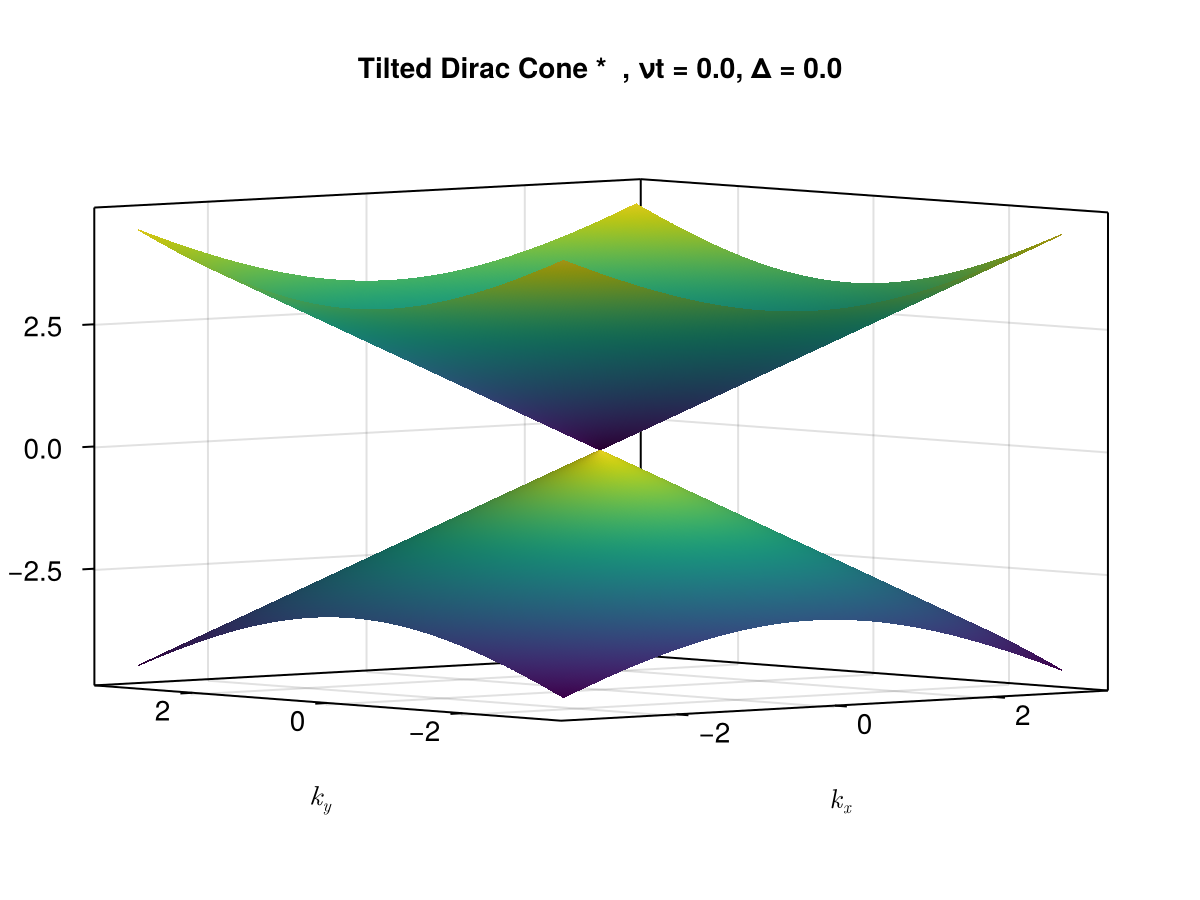

CairoMakie.Screen{IMAGE}


In [25]:
plot_bands3D(νt = 0.0, Δ = 0.0)

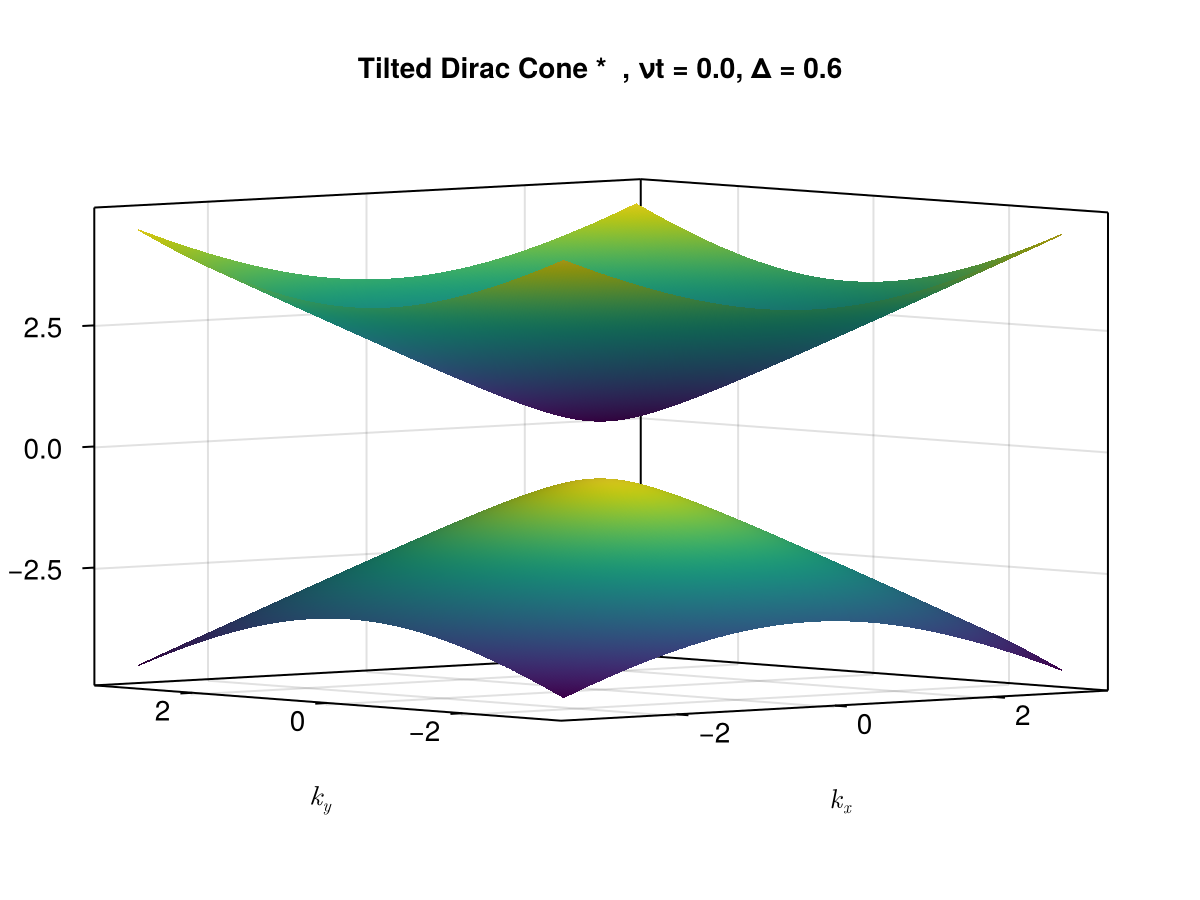

CairoMakie.Screen{IMAGE}


In [26]:
plot_bands3D(νt = 0.0, Δ = 0.6)

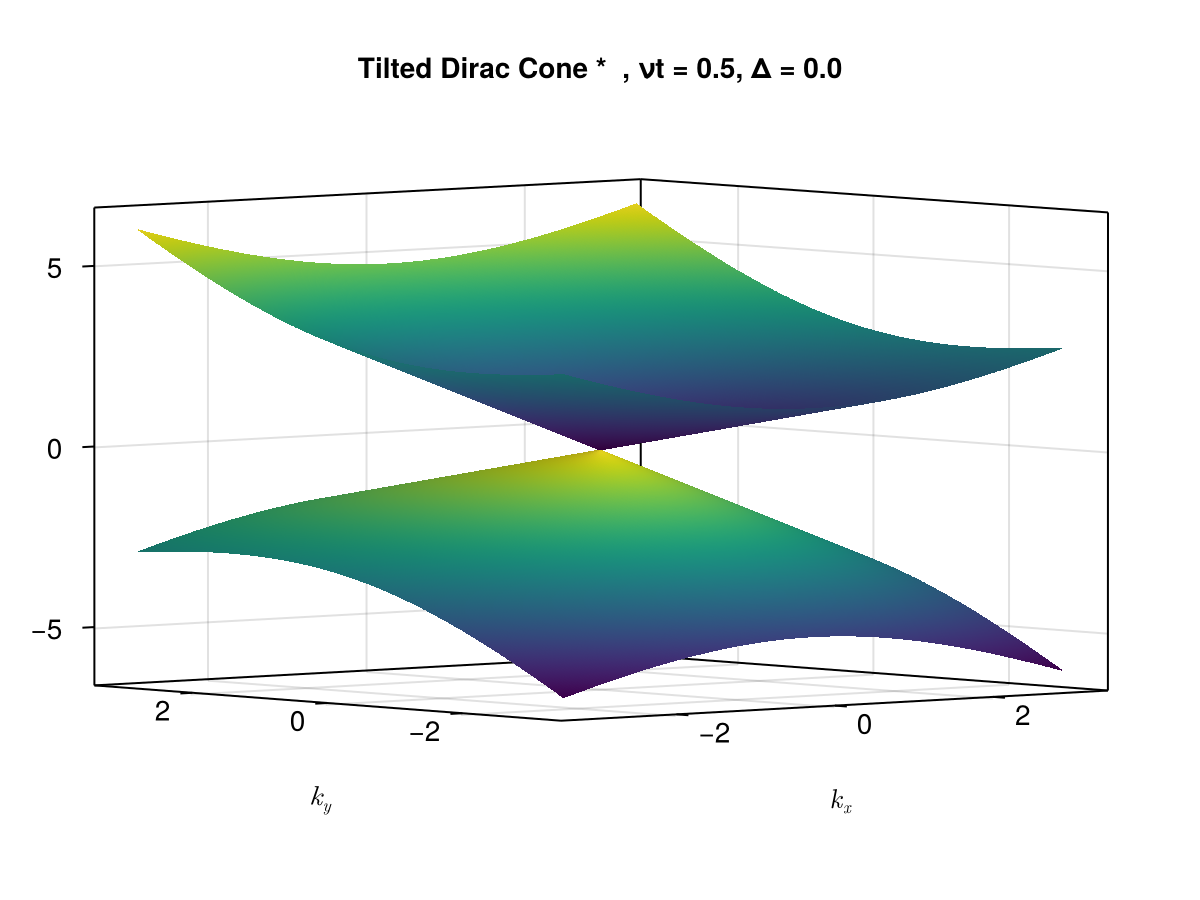

CairoMakie.Screen{IMAGE}


In [27]:
plot_bands3D(νt = 0.5, Δ = 0.0)

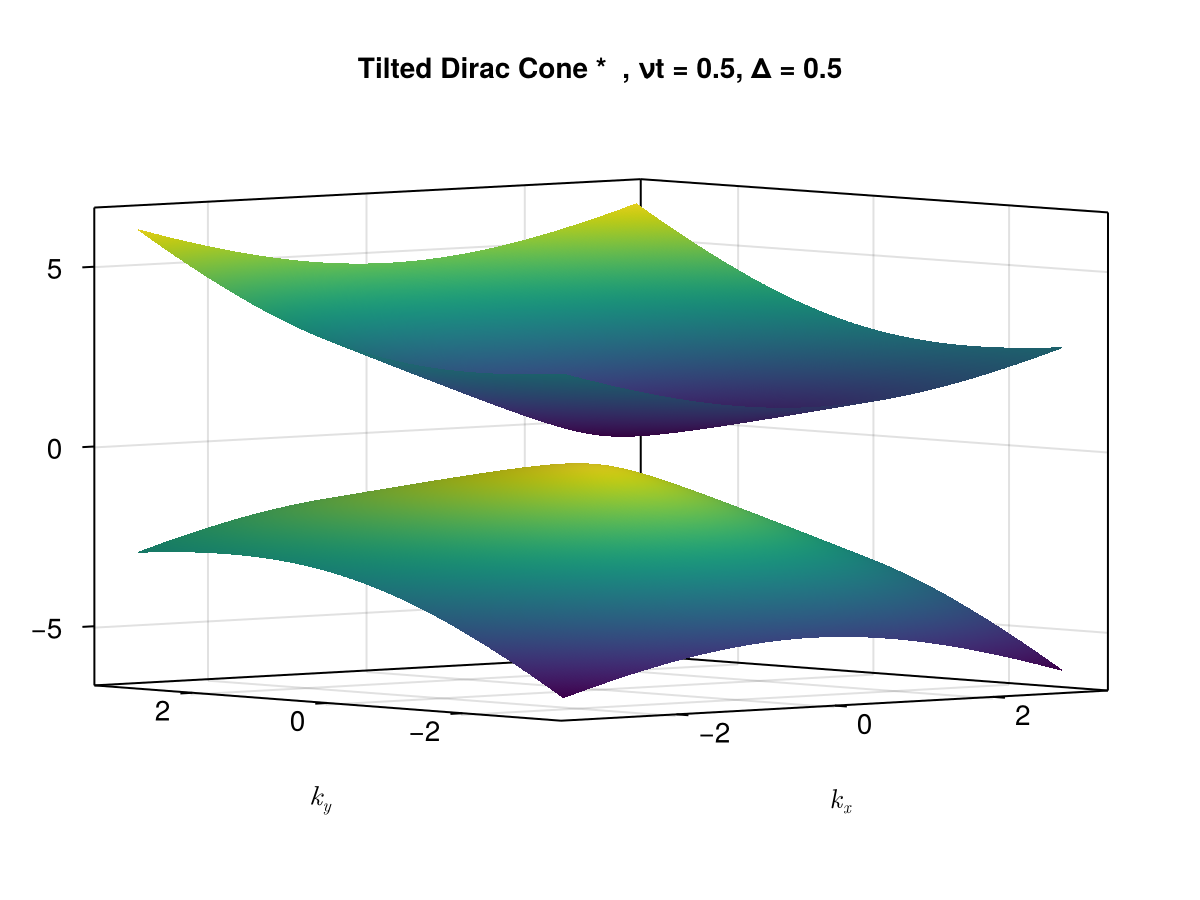

CairoMakie.Screen{IMAGE}


In [28]:
plot_bands3D(νt = 0.5, Δ = 0.5)

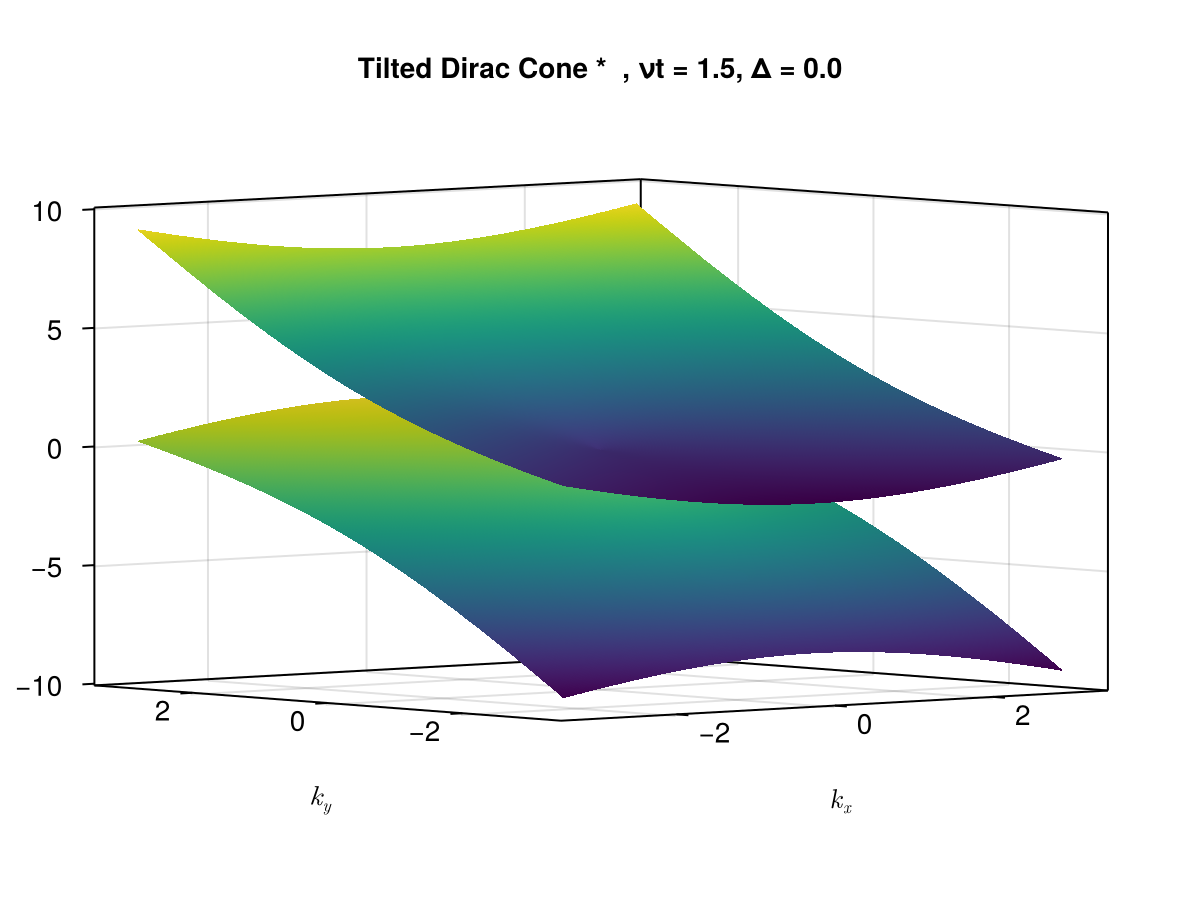

CairoMakie.Screen{IMAGE}


In [29]:
plot_bands3D(νt = 1.5, Δ = 0.0)

## Berry Curvature Polarizability Calculations (BCPH and BCPD)

In [30]:
@inline function QM_xy(k::Vector{Float64},
    νt::Float64, 
    Δ::Float64, 
    νF::Float64 = 1.0, 
    band::Int = 1)

    (E, U) = eigensystem_dirac_fermion(k, νt, Δ, νF)
    Vxb::Matrix{ComplexF64} = U' * Vx(k, νt, νF) * U
    Vyb::Matrix{ComplexF64} = U' * Vy(k, νt, νF) * U

    bck::Float64 = 0.0

    for n ∈ 1:2
        if (n != band)
            bck += real(Vxb[band, n] * Vyb[n, band]) / (E[band] - E[n])^2
        end
    end
    return bck
end



@inline function BRrenorm_QM(k::Vector{Float64},
    νt::Float64, 
    Δ::Float64,
    a::Int, 
    b::Int,
    νF::Float64 = 1.0
    )
    """
    Band-Renormalized Quantum Metric -- Related to Polarizability.  
    Input: 
        - parameters: νt, Δ
        - a, b: Spatial SO(2) Indices 
    Output: 
        - Gives a matrix in the band basis, here a 2 x 2 matrix connecting the different modes of the Dirac operator 
    """

    (E, U) = eigensystem_dirac_fermion(k, νt, Δ, νF)
    V_orb::Vector{Matrix{ComplexF64}} = V(νt, νF)
    Vmn::Vector{Matrix{ComplexF64}} = [U' * V_orb[1] * U, U' * V_orb[2] * U]

    ωmn::Matrix{Float64} = E' .- E
    ωmn[ωmn .== 0] .= Inf   # This will kill the diagonal terms 

    Xmn::Vector{Matrix{ComplexF64}} = [-im * Vmn[1] ./ ωmn, -im * Vmn[2] ./ ωmn]

    real.(transpose(Xmn)[a] .* Xmn[b] ./ ωmn)

end



@inline function BRrenorm_QM(E::Vector{Float64}, U::Matrix{ComplexF64},
    νt::Float64, 
    Δ::Float64,
    a::Int, 
    b::Int,
    νF::Float64 = 1.0
    )
    """
    Band-Renormalized Quantum Metric -- Related to Polarizability.  
    Input: 
        - parameters: νt, Δ
        - a, b: Spatial SO(2) Indices 
    Output: 
        - Gives a matrix in the band basis, here a 2 x 2 matrix connecting the different modes of the Dirac operator 
    """

    V_orb::Vector{Matrix{ComplexF64}} = V(νt, νF)
    Vmn::Vector{Matrix{ComplexF64}} = [U' * V_orb[1] * U, U' * V_orb[2] * U]

    ωmn::Matrix{Float64} = E' .- E
    ωmn[ωmn .== 0] .= Inf   # This will kill the diagonal terms 

    Xmn::Vector{Matrix{ComplexF64}} = [-im * Vmn[1] ./ ωmn, -im * Vmn[2] ./ ωmn]

    real.(transpose(Xmn)[a] .* Xmn[b] ./ ωmn)

end


@inline function BRrenorm_QM(E::Vector{Float64}, Vmn::Vector{Matrix{ComplexF64}},
    νt::Float64, 
    Δ::Float64,
    a::Int, 
    b::Int,
    νF::Float64 = 1.0
    )
    """
    Band-Renormalized Quantum Metric -- Related to Polarizability.  
    Input: 
        - parameters: νt, Δ
        - a, b: Spatial SO(2) Indices 
    Output: 
        - Gives a matrix in the band basis, here a 2 x 2 matrix connecting the different modes of the Dirac operator 
    """
    ωmn::Matrix{Float64} = E' .- E
    ωmn[ωmn .== 0] .= Inf   # This will kill the diagonal terms 

    Xmn::Vector{Matrix{ComplexF64}} = [-im * Vmn[1] ./ ωmn, -im * Vmn[2] ./ ωmn]

    real.(transpose(Xmn)[a] .* Xmn[b] ./ ωmn)

end




## Differential of the Fermi-Dirac Distribution  
@inline function dFD_dk(E::Float64, μ::Float64, TKelv::Float64)
    """
    Derivatives of the Fermi-Dirac Function -- Needed to construct Λ_BCPH and Λ_BCPD 
    """
    expf::Float64 = exp((11604.518 / TKelv) * (E - μ))
    -(11604.518 / TKelv) * expf / (1.0 + expf)^2
end

@inline function FD(E::Float64, μ::Float64, TKelv::Float64)
    """
    The Fermi-Dirac Function -- Needed to construct Λ_BCPH and Λ_BCPD 
    """
    1.0 / (1.0 + exp((11604.518 / TKelv) * (E - μ)))
end


@inline function Λ_BCPH_fdiff_0Klv(k::Vector{Float64},
    νt::Float64,
    Δ::Float64,  
    a::Int, 
    b::Int, 
    c::Int,
    m::Int, 
    ϵ::Float64 = 1e-6,
    νF::Float64 = 1.0)
    """
    Berry Curvature Polarizability Hall Components -- Depends on the band index 
    Each Band has a Hall Polarizability and a 'Dissipative' Polarizability 
    This uses the finite difference numerical method 
    """
    Dk::Vector{Vector{Float64}} = [[ϵ, 0.0], [0.0, ϵ]]
    abc = (BRrenorm_QM(k + Dk[a], νt, Δ, b, c, νF) - BRrenorm_QM(k, νt, Δ, b, c, νF)) / ϵ
    bac = (BRrenorm_QM(k + Dk[b], νt, Δ, a, c, νF) - BRrenorm_QM(k, νt, Δ, a, c, νF)) / ϵ
    cab = (BRrenorm_QM(k + Dk[c], νt, Δ, a, b, νF) - BRrenorm_QM(k, νt, Δ, a, b, νF)) / ϵ
    res::Matrix{Float64} = 2.0 * abc - bac - cab
    sum(res[m, :])
end




@inline function σ_BCPD_fdiff_integrand(E::Vector{Float64}, U::Matrix{ComplexF64}, 
    E_ϵ::Vector{Vector{Float64}}, U_ϵ::Vector{Matrix{ComplexF64}},
    νt::Float64,
    Δ::Float64,  
    a::Int, 
    b::Int, 
    c::Int,
    TKelv::Float64,
    μvals::Vector{Float64}, 
    ϵ::Float64 = 1e-6,
    νF::Float64 = 1.0)
    """
    Berry Curvature Polarizability Hall Components -- Depends on the band index 
    Each Band has a Hall Polarizability and a 'Dissipative' Polarizability 
    This uses the finite difference numerical method 
    """
    Dk::Vector{Vector{Float64}} = [[ϵ, 0.0], [0.0, ϵ]]
    abc = (BRrenorm_QM(E_ϵ[a], U_ϵ[a], νt, Δ, b, c, νF) - BRrenorm_QM(E, U, νt, Δ, b, c, νF)) / ϵ
    bac = (BRrenorm_QM(E_ϵ[b], U_ϵ[b], νt, Δ, a, c, νF) - BRrenorm_QM(E, U, νt, Δ, a, c, νF)) / ϵ
    cab = (BRrenorm_QM(E_ϵ[c], U_ϵ[c], νt, Δ, a, b, νF) - BRrenorm_QM(E, U, νt, Δ, a, b, νF)) / ϵ
    mat_elem::Matrix{Float64} = abc + bac + cab
    res::Vector{Float64} = zeros(Float64, size(μvals, 1))
    for m ∈ 1:2
        res += sum(mat_elem[m, :]) * FD.(Ref(E[m]), μvals, Ref(TKelv))
    end
    res
end




@inline function Λ_BCPD_fdiff_0Klv(k::Vector{Float64},
    νt::Float64,
    Δ::Float64,  
    a::Int, 
    b::Int, 
    c::Int,
    m::Int, 
    ϵ::Float64 = 1e-6,
    νF::Float64 = 1.0)
    """
    Berry Curvature Polarizability Hall Components -- Depends on the band index 
    Each Band has a Hall Polarizability and a 'Dissipative' Polarizability 
    This uses the finite difference numerical method 
    """
    Dk::Vector{Vector{Float64}} = [[ϵ, 0.0], [0.0, ϵ]]
    abc = (BRrenorm_QM(k + Dk[a], νt, Δ, b, c, νF) - BRrenorm_QM(k, νt, Δ, b, c, νF)) / ϵ
    bac = (BRrenorm_QM(k + Dk[b], νt, Δ, a, c, νF) - BRrenorm_QM(k, νt, Δ, a, c, νF)) / ϵ
    cab = (BRrenorm_QM(k + Dk[c], νt, Δ, a, b, νF) - BRrenorm_QM(k, νt, Δ, a, b, νF)) / ϵ
    res::Matrix{Float64} = abc + bac + cab
    sum(res[m, :])
end


function Plot_Λ_BCPH_fdiff_0Klv(;
    νt::Float64,
    Δ::Float64,  
    a::Int, 
    b::Int, 
    c::Int,
    m::Int, 
    ϵ::Float64 = 1e-6,
    color_min::Float64 = -1000.0,
    color_max::Float64 = 1000.0,
    νF::Float64 = 1.0)
    """
    Berry Curvature Polarizability Hall Components integrated over momentum space 
    Each Band has a Hall Polarizability and a 'Dissipative' Polarizability 
    This uses the finite difference numerical method 
    """
    lim = 0.3; nps = 200

    map_num_xyz = Dict(1 => "x", 2 => "y")

    rng = LinRange(-lim, lim, nps)
    grid = Matrix{Vector{Float64}}(undef, nps, nps)
    for (n, kx) ∈ enumerate(rng)
        for (m, ky) ∈ enumerate(rng)
            grid[n, m] = [kx, ky]
        end
    end 

    Λvals::Matrix{Float64} = Λ_BCPH_fdiff_0Klv.(grid, Ref(νt), Ref(Δ), Ref(a), Ref(b), Ref(c), Ref(m), Ref(ϵ), Ref(νF))
    f = Figure()
    ax = Axis(f[1, 1], title = "ΛBCPH $(map_num_xyz[a])$(map_num_xyz[b])$(map_num_xyz[c]) for band $m")
    m = heatmap!(ax, Λvals, colormap = :bwr, colorrange = (color_min, color_max))
    Colorbar(f[1, 2], m)
    f

end

function Plot_Λ_BCPD_fdiff_0Klv(;
    νt::Float64,
    Δ::Float64,  
    a::Int, 
    b::Int, 
    c::Int,
    m::Int, 
    ϵ::Float64 = 1e-6,
    color_min::Float64 = -1000.0,
    color_max::Float64 = 1000.0,
    νF::Float64 = 1.0)
    """
    Berry Curvature Polarizability Hall Components integrated over momentum space 
    Each Band has a Hall Polarizability and a 'Dissipative' Polarizability 
    This uses the finite difference numerical method 
    """
    lim = 0.3; nps = 200

    map_num_xyz = Dict(1 => "x", 2 => "y")

    rng = LinRange(-lim, lim, nps)
    grid = Matrix{Vector{Float64}}(undef, nps, nps)
    for (n, kx) ∈ enumerate(rng)
        for (m, ky) ∈ enumerate(rng)
            grid[n, m] = [kx, ky]
        end
    end 

    Λvals::Matrix{Float64} = Λ_BCPD_fdiff_0Klv.(grid, Ref(νt), Ref(Δ), Ref(a), Ref(b), Ref(c), Ref(m), Ref(ϵ), Ref(νF))
    f = Figure()
    ax = Axis(f[1, 1], title = "ΛBCPD $(map_num_xyz[a])$(map_num_xyz[b])$(map_num_xyz[c]) for band $m")
    m = heatmap!(ax, Λvals, colormap = :bwr, colorrange = (color_min, color_max))
    Colorbar(f[1, 2], m)
    f

end



Plot_Λ_BCPD_fdiff_0Klv (generic function with 1 method)

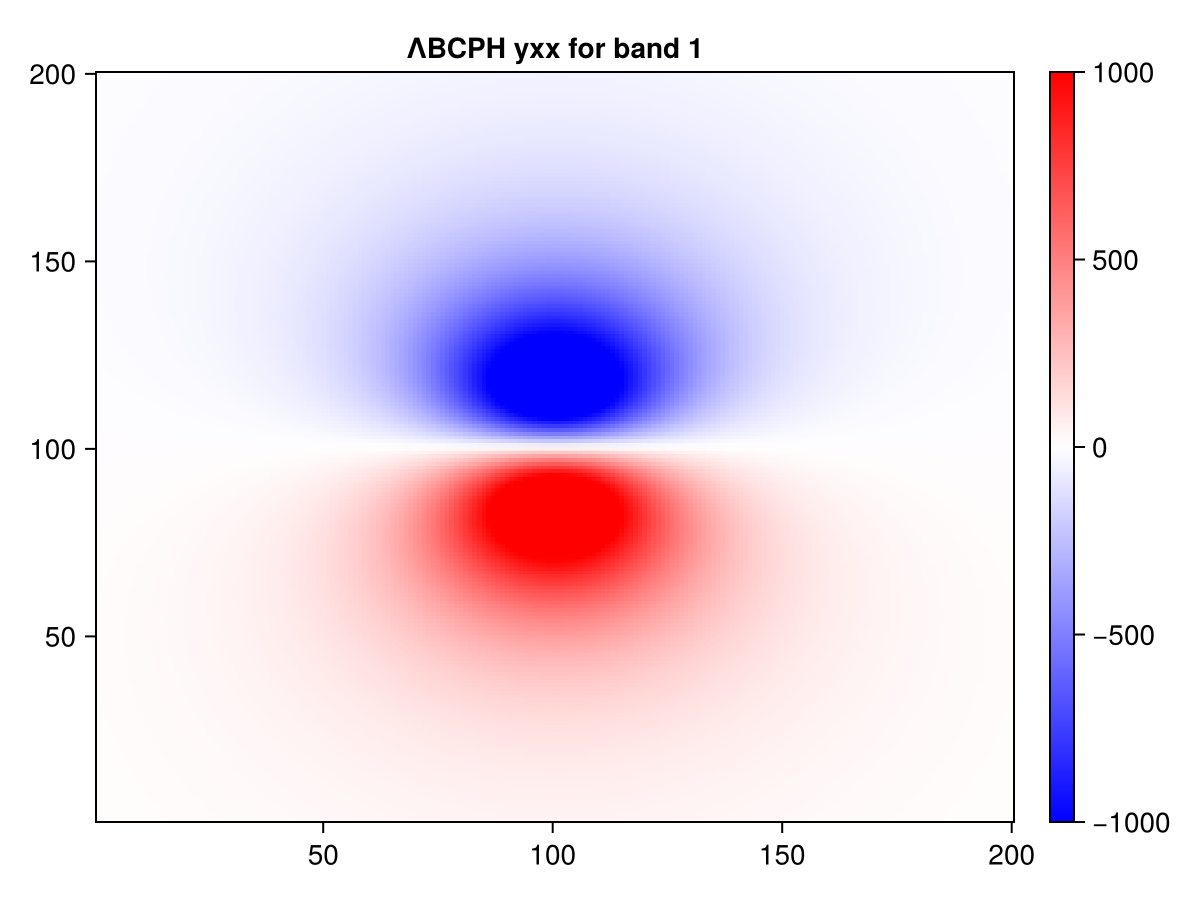

In [31]:
Plot_Λ_BCPH_fdiff_0Klv(νt = 0.1, Δ = 0.1, a = 2, b = 1, c = 1, m = 1, color_min = -1000.0, color_max = 1000.0)

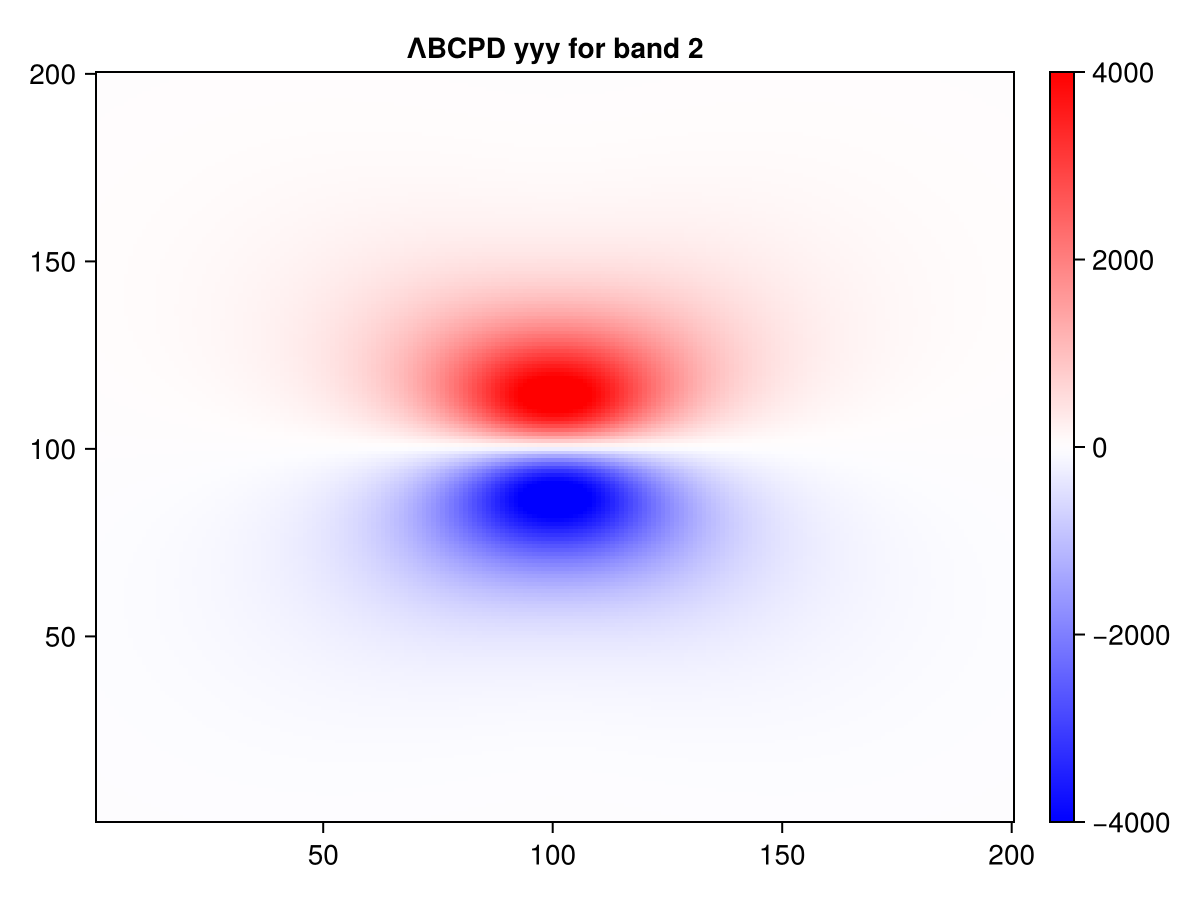

In [32]:
Plot_Λ_BCPD_fdiff_0Klv(νt = 0.1, Δ = 0.1, a = 2, b = 2, c = 2, m = 2, color_min = -4000.0, color_max = 4000.0)

## Calculation of the BCPH and BCPD Conductivities 

In [33]:
@inline function σ_BCPH_fdiff_integrand(E::Vector{Float64}, U::Matrix{ComplexF64}, 
    E_ϵ::Vector{Vector{Float64}}, U_ϵ::Vector{Matrix{ComplexF64}},
    νt::Float64,
    Δ::Float64,  
    a::Int, 
    b::Int, 
    c::Int,
    TKelv::Float64,
    μvals::Vector{Float64}, 
    ϵ::Float64 = 1e-6,
    νF::Float64 = 1.0)
    """
    Berry Curvature Polarizability Hall Components -- Depends on the band index 
    Each Band has a Hall Polarizability and a 'Dissipative' Polarizability 
    This uses the finite difference numerical method 
    """
    Dk::Vector{Vector{Float64}} = [[ϵ, 0.0], [0.0, ϵ]]
    abc = (BRrenorm_QM(E_ϵ[a], U_ϵ[a], νt, Δ, b, c, νF) - BRrenorm_QM(E, U, νt, Δ, b, c, νF)) / ϵ
    bac = (BRrenorm_QM(E_ϵ[b], U_ϵ[b], νt, Δ, a, c, νF) - BRrenorm_QM(E, U, νt, Δ, a, c, νF)) / ϵ
    cab = (BRrenorm_QM(E_ϵ[c], U_ϵ[c], νt, Δ, a, b, νF) - BRrenorm_QM(E, U, νt, Δ, a, b, νF)) / ϵ
    mat_elem::Matrix{Float64} = 2.0 * abc - bac - cab
    res::Vector{Float64} = zeros(Float64, size(μvals, 1))
    for m ∈ 1:2
        res += sum(mat_elem[m, :]) * FD.(Ref(E[m]), μvals, Ref(TKelv))
    end
    res
end


function σ_BCPH_fdiffs(;νt::Float64, Δ::Float64, TKelv::Float64,
    a::Int, 
    b::Int,
    c::Int,
    lim_k::Float64, 
    nps::Int,
    μmin::Float64,
    μmax::Float64,
    μnum::Int, 
    ϵ::Float64 = 1e-6,
    νF::Float64 = 1.0)
    """
    This function calculates the BCPH Conductivity as a function of the chemical potential (Fermi surface)
        Note: 
        This function is more computationally demanding.
        There is a three-dimensional integration (2D FBZ x 1D Fermi energies) -> This is discretized to a 3D grid 
        --- Good approach is to use MPI or some other parallelization mechanism e.g. the Distributed Package 
    """
    area::Float64 = 4.0 * lim_k^2
    nk_tot::Float64 = nps^2
    dkxdky::Float64 = area / nk_tot

    # Differential operator 
    Dk::Vector{Vector{Float64}} = [[ϵ, 0.0], [0.0, ϵ]]
    
    # First, generate momentum grid 
    rng = LinRange(-lim_k, lim_k, nps)
    grid = Matrix{Vector{Float64}}(undef, nps, nps)
    for (n, kx) ∈ enumerate(rng)
        for (m, ky) ∈ enumerate(rng)
            grid[n, m] = [kx, ky]
        end # m
    end  # n

    # Chemical Potential 
    μvals::Vector{Float64} = LinRange(μmin, μmax, μnum)

    # result: 
    res::Vector{Float64} = zeros(Float64, μnum)

    for k ∈ grid
        (E, U)       = eigensystem_dirac_fermion(k, νt, Δ, νF)
        (E_ϵ1, U_ϵ1) = eigensystem_dirac_fermion(k + Dk[1], νt, Δ, νF)
        (E_ϵ2, U_ϵ2) = eigensystem_dirac_fermion(k + Dk[2], νt, Δ, νF)
        E_ϵ::Vector{Vector{Float64}} = [E_ϵ1, E_ϵ2]
        U_ϵ::Vector{Matrix{ComplexF64}} = [U_ϵ1, U_ϵ2]
        res += σ_BCPH_fdiff_integrand(E, U, E_ϵ, U_ϵ, νt, Δ, a, b, c, TKelv, μvals, νF)
        
    end
    res * dkxdky
end

function σ_BCPD_fdiffs(;νt::Float64, Δ::Float64, TKelv::Float64,
    a::Int, 
    b::Int,
    c::Int,
    lim_k::Float64, 
    nps::Int,
    μmin::Float64,
    μmax::Float64,
    μnum::Int, 
    ϵ::Float64 = 1e-6,
    νF::Float64 = 1.0)
    """
    This function calculates the BCPH Conductivity as a function of the chemical potential (Fermi surface)
        Note: 
        This function is more computationally demanding.
        There is a three-dimensional integration (2D FBZ x 1D Fermi energies) -> This is discretized to a 3D grid 
        --- Good approach is to use MPI or some other parallelization mechanism e.g. the Distributed Package 
    """
    area::Float64 = 4.0 * lim_k^2
    nk_tot::Float64 = nps^2
    dkxdky::Float64 = area / nk_tot

    # Differential operator 
    Dk::Vector{Vector{Float64}} = [[ϵ, 0.0], [0.0, ϵ]]
    
    # First, generate momentum grid 
    rng = LinRange(-lim_k, lim_k, nps)
    grid = Matrix{Vector{Float64}}(undef, nps, nps)
    for (n, kx) ∈ enumerate(rng)
        for (m, ky) ∈ enumerate(rng)
            grid[n, m] = [kx, ky]
        end # m
    end  # n

    # Chemical Potential 
    μvals::Vector{Float64} = LinRange(μmin, μmax, μnum)

    # result: 
    res::Vector{Float64} = zeros(Float64, μnum)

    for k ∈ grid
        (E, U)       = eigensystem_dirac_fermion(k, νt, Δ, νF)
        (E_ϵ1, U_ϵ1) = eigensystem_dirac_fermion(k + Dk[1], νt, Δ, νF)
        (E_ϵ2, U_ϵ2) = eigensystem_dirac_fermion(k + Dk[2], νt, Δ, νF)
        E_ϵ::Vector{Vector{Float64}} = [E_ϵ1, E_ϵ2]
        U_ϵ::Vector{Matrix{ComplexF64}} = [U_ϵ1, U_ϵ2]
        res += σ_BCPD_fdiff_integrand(E, U, E_ϵ, U_ϵ, νt, Δ, a, b, c, TKelv, μvals, ϵ, νF)
        
    end
    res * dkxdky
end



σ_BCPD_fdiffs (generic function with 1 method)

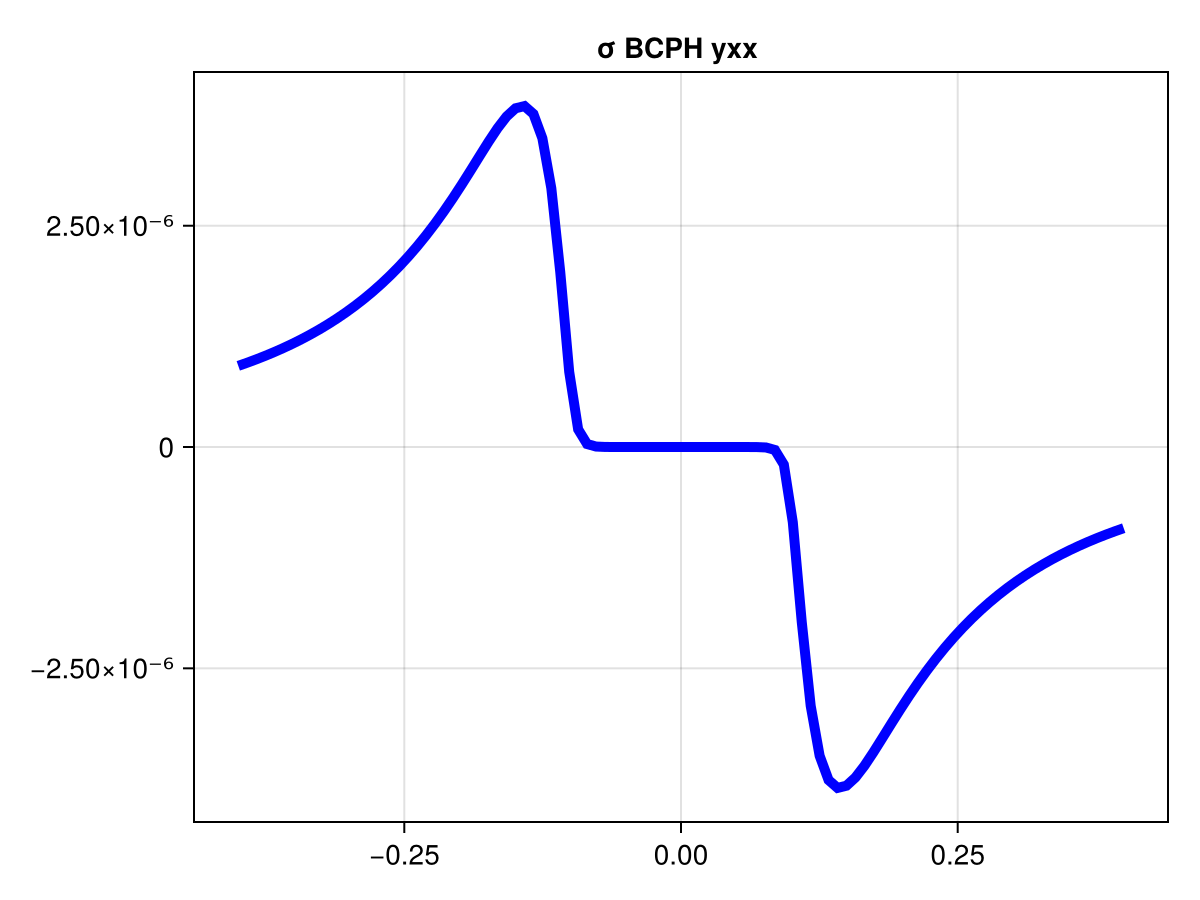

In [34]:

let μmin = -0.4, μmax = 0.4, μnum = 100, lim_k = 0.5, nps = 500, νt = 0.1, Δ = 0.1, TKelv = 50.0, a = 2, b = 1, c = 1
    # Chemical Potential 
    μvals::Vector{Float64} = LinRange(μmin, μmax, μnum)

    # Main computation 
    res = σ_BCPH_fdiffs(νt = νt, Δ = Δ, a = a, b = b, c = c, TKelv = TKelv, lim_k = lim_k, nps = nps, μmin = μmin, μmax = μmax, μnum = μnum)

    # Plotting 
    f = Figure()
    ax = Axis(f[1, 1], title = "σ BCPH $(num_to_xyz[a])$(num_to_xyz[b])$(num_to_xyz[c]) ")
    m = lines!(ax, μvals, res, linewidth = 5.0, color = :blue)
    f
end

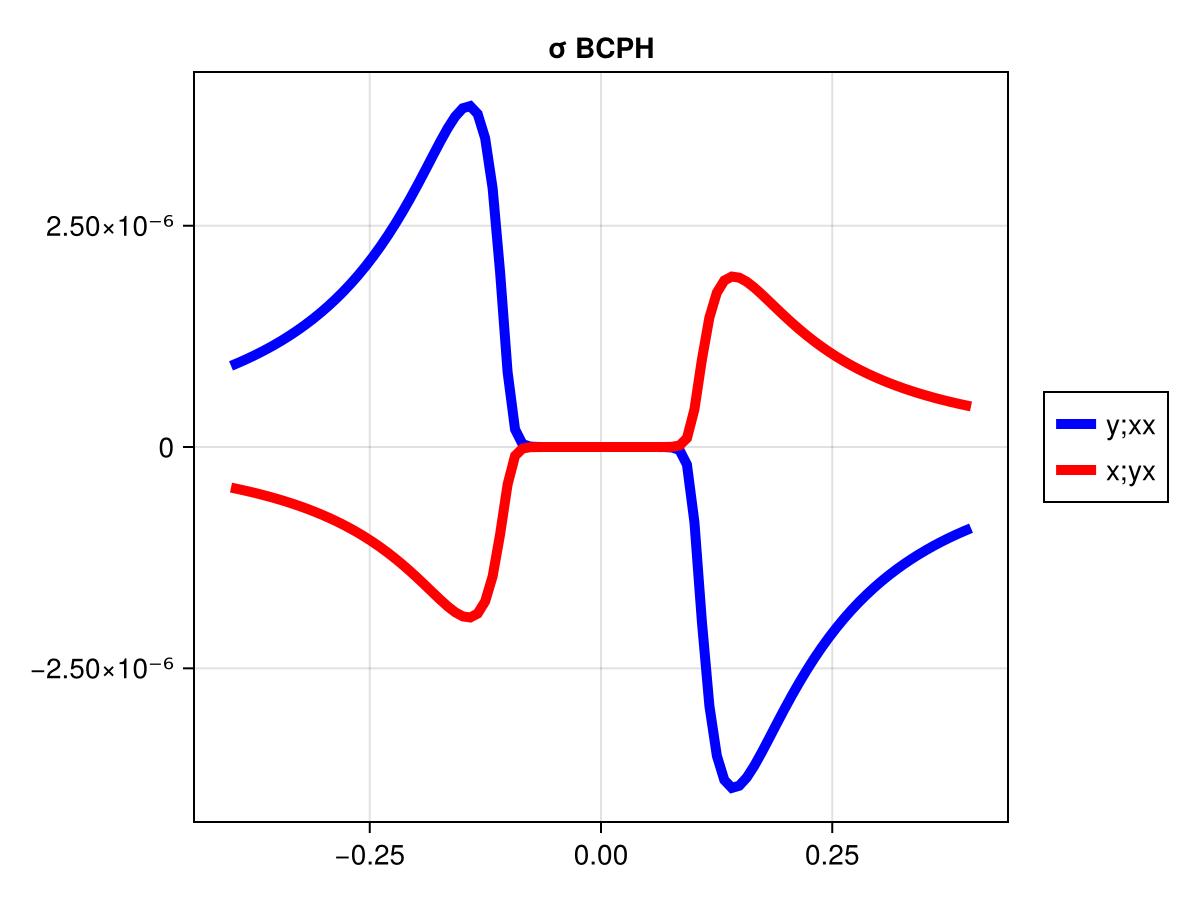

In [35]:
let μmin = -0.4, μmax = 0.4, μnum = 100, lim_k = 0.5, nps = 500, νt = 0.1, Δ = 0.1, TKelv = 50.0
    # Chemical Potential 
    μvals::Vector{Float64} = LinRange(μmin, μmax, μnum)

    # Main computation 
    res1 = σ_BCPH_fdiffs(νt = νt, Δ = Δ, a = 2, b = 1, c = 1, TKelv = TKelv, lim_k = lim_k, nps = nps, μmin = μmin, μmax = μmax, μnum = μnum)
    res2 = σ_BCPH_fdiffs(νt = νt, Δ = Δ, a = 1, b = 2, c = 1, TKelv = TKelv, lim_k = lim_k, nps = nps, μmin = μmin, μmax = μmax, μnum = μnum)

    # Plotting 
    f = Figure()
    ax = Axis(f[1, 1], title = "σ BCPH")
    m1 = lines!(ax, μvals, res1, linewidth = 5.0, color = :blue)
    m2 = lines!(ax, μvals, res2, linewidth = 5.0, color = :red)
    legend = Legend(f, [m1, m2], ["y;xx", "x;yx"])
    f[1, 2] = legend
    f
end

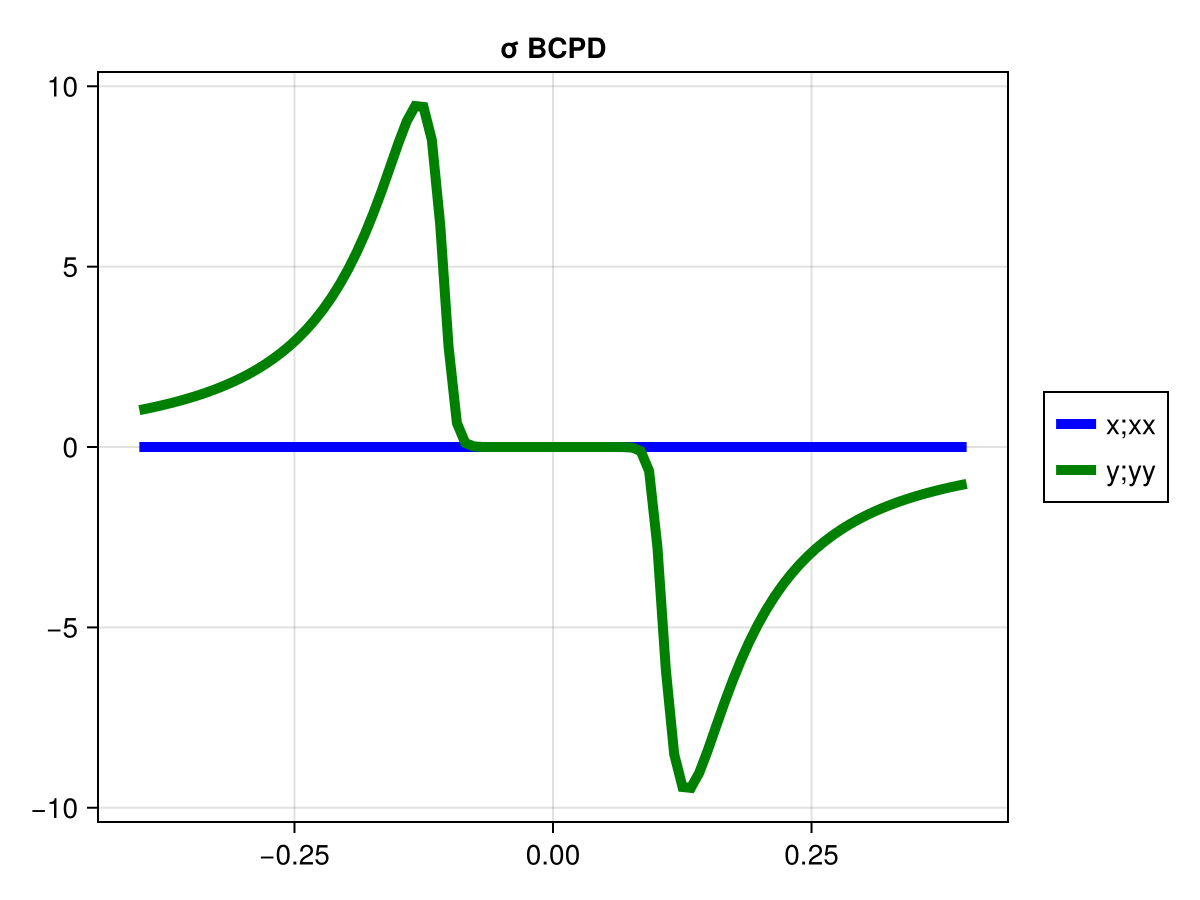

In [36]:
let μmin = -0.4, μmax = 0.4, μnum = 100, lim_k = 0.5, nps = 500, νt = 0.1, Δ = 0.1, TKelv = 50.0
    # Chemical Potential 
    μvals::Vector{Float64} = LinRange(μmin, μmax, μnum)

    # Main computation 
    res1 = σ_BCPD_fdiffs(νt = νt, Δ = Δ, a = 1, b = 1, c = 1, TKelv = TKelv, lim_k = lim_k, nps = nps, μmin = μmin, μmax = μmax, μnum = μnum)
    res2 = σ_BCPD_fdiffs(νt = νt, Δ = Δ, a = 2, b = 2, c = 2, TKelv = TKelv, lim_k = lim_k, nps = nps, μmin = μmin, μmax = μmax, μnum = μnum)

    # Plotting 
    f = Figure()
    ax = Axis(f[1, 1], title = "σ BCPD")
    m1 = lines!(ax, μvals, res1, linewidth = 5.0, color = :blue)
    m2 = lines!(ax, μvals, res2, linewidth = 5.0, color = :green)
    legend = Legend(f, [m1, m2], ["x;xx", "y;yy"])
    f[1, 2] = legend
    f
end

### Same Calculation, but without finite differences i.e. integrating by parts and evaluating the derivative of Dirac-Delta function

In [37]:
using Symbolics
let 
    @variables F E μ β
    F = 1 / (1 + exp(β * (E - μ)))
    DE = Differential(E)
    dF_dE = simplify(expand_derivatives(DE(F)))
end


(-exp((E - μ)*β)*β) / ((1 + exp((E - μ)*β))^2)

In [38]:
@inline function σ_BCPD_integrand(E::Vector{Float64}, U::Matrix{ComplexF64}, 
    νt::Float64,
    Δ::Float64,  
    a::Int, 
    b::Int, 
    c::Int,
    TKelv::Float64,
    μvals::Vector{Float64}, 
    νF::Float64 = 1.0)
    """
    Berry Curvature Polarizability Hall Components -- Depends on the band index 
    Each Band has a Hall Polarizability and a 'Dissipative' Polarizability 
    """
    V_orb::Vector{Matrix{ComplexF64}} = V(νt, νF)
    Vmn::Vector{Matrix{ComplexF64}} = [U' * V_orb[1] * U, U' * V_orb[2] * U]

    bc = BRrenorm_QM(E, Vmn, νt, Δ, b, c, νF)
    ac = BRrenorm_QM(E, Vmn, νt, Δ, a, c, νF)
    ab = BRrenorm_QM(E, Vmn, νt, Δ, a, b, νF)
    res::Vector{Float64} = zeros(Float64, size(μvals, 1))
    for m ∈ 1:2
        res += sum(real(Vmn[a][m, m]) * bc[m, :] + real(Vmn[b][m, m]) * ac[m, :] + real(Vmn[c][m, m]) * ab[m, :]) * dFD_dk.(Ref(E[m]), μvals, Ref(TKelv))
    end
    -res # minus since this is related to the finite diff method by an integration by parts
end


function σ_BCPD(;νt::Float64, Δ::Float64, TKelv::Float64,
    a::Int, 
    b::Int,
    c::Int,
    lim_k::Float64, 
    nps::Int,
    μmin::Float64,
    μmax::Float64,
    μnum::Int, 
    νF::Float64 = 1.0)
    """
    This function calculates the BCPH Conductivity as a function of the chemical potential (Fermi surface)
        Note: 
        This function is more computationally demanding.
        There is a three-dimensional integration (2D FBZ x 1D Fermi energies) -> This is discretized to a 3D grid 
        --- Good approach is to use MPI or some other parallelization mechanism e.g. the Distributed Package 
    """
    area::Float64 = 4.0 * lim_k^2
    nk_tot::Float64 = nps^2
    dkxdky::Float64 = area / nk_tot

    
    # First, generate momentum grid 
    rng = LinRange(-lim_k, lim_k, nps)
    grid = Matrix{Vector{Float64}}(undef, nps, nps)
    for (n, kx) ∈ enumerate(rng)
        for (m, ky) ∈ enumerate(rng)
            grid[n, m] = [kx, ky]
        end # m
    end  # n

    # Chemical Potential 
    μvals::Vector{Float64} = LinRange(μmin, μmax, μnum)

    # result: 
    res::Vector{Float64} = zeros(Float64, μnum)

    for k ∈ grid
        (E, U)       = eigensystem_dirac_fermion(k, νt, Δ, νF)
        res += σ_BCPD_integrand(E, U, νt, Δ, a, b, c, TKelv, μvals, νF)
        
    end
    res * dkxdky
end


@inline function σ_BCPH_integrand(E::Vector{Float64}, U::Matrix{ComplexF64}, 
    νt::Float64,
    Δ::Float64,  
    a::Int, 
    b::Int, 
    c::Int,
    TKelv::Float64,
    μvals::Vector{Float64}, 
    νF::Float64 = 1.0)
    """
    Berry Curvature Polarizability Hall Components -- Depends on the band index 
    Each Band has a Hall Polarizability and a 'Dissipative' Polarizability 
    """
    V_orb::Vector{Matrix{ComplexF64}} = V(νt, νF)
    Vmn::Vector{Matrix{ComplexF64}} = [U' * V_orb[1] * U, U' * V_orb[2] * U]

    bc = BRrenorm_QM(E, Vmn, νt, Δ, b, c, νF)
    ac = BRrenorm_QM(E, Vmn, νt, Δ, a, c, νF)
    ab = BRrenorm_QM(E, Vmn, νt, Δ, a, b, νF)
    res::Vector{Float64} = zeros(Float64, size(μvals, 1))
    for m ∈ 1:2
        res += sum(2.0 * real(Vmn[a][m, m]) * bc[m, :] - real(Vmn[b][m, m]) * ac[m, :] - real(Vmn[c][m, m]) * ab[m, :]) * dFD_dk.(Ref(E[m]), μvals, Ref(TKelv))
    end
    -res # minus since this is related to the finite diff method by an integration by parts 
end


function σ_BCPH(;νt::Float64, Δ::Float64, TKelv::Float64,
    a::Int, 
    b::Int,
    c::Int,
    lim_k::Float64, 
    nps::Int,
    μmin::Float64,
    μmax::Float64,
    μnum::Int, 
    νF::Float64 = 1.0)
    """
    This function calculates the BCPH Conductivity as a function of the chemical potential (Fermi surface)
        Note: 
        This function is more computationally demanding.
        There is a three-dimensional integration (2D FBZ x 1D Fermi energies) -> This is discretized to a 3D grid 
        --- Good approach is to use MPI or some other parallelization mechanism e.g. the Distributed Package 
    """
    area::Float64 = 4.0 * lim_k^2
    nk_tot::Float64 = nps^2
    dkxdky::Float64 = area / nk_tot

    
    # First, generate momentum grid 
    rng = LinRange(-lim_k, lim_k, nps)
    grid = Matrix{Vector{Float64}}(undef, nps, nps)
    for (n, kx) ∈ enumerate(rng)
        for (m, ky) ∈ enumerate(rng)
            grid[n, m] = [kx, ky]
        end # m
    end  # n

    # Chemical Potential 
    μvals::Vector{Float64} = LinRange(μmin, μmax, μnum)

    # result: 
    res::Vector{Float64} = zeros(Float64, μnum)

    for k ∈ grid
        (E, U)       = eigensystem_dirac_fermion(k, νt, Δ, νF)
        res += σ_BCPH_integrand(E, U, νt, Δ, a, b, c, TKelv, μvals, νF)
        
    end
    res * dkxdky
end




σ_BCPH (generic function with 1 method)

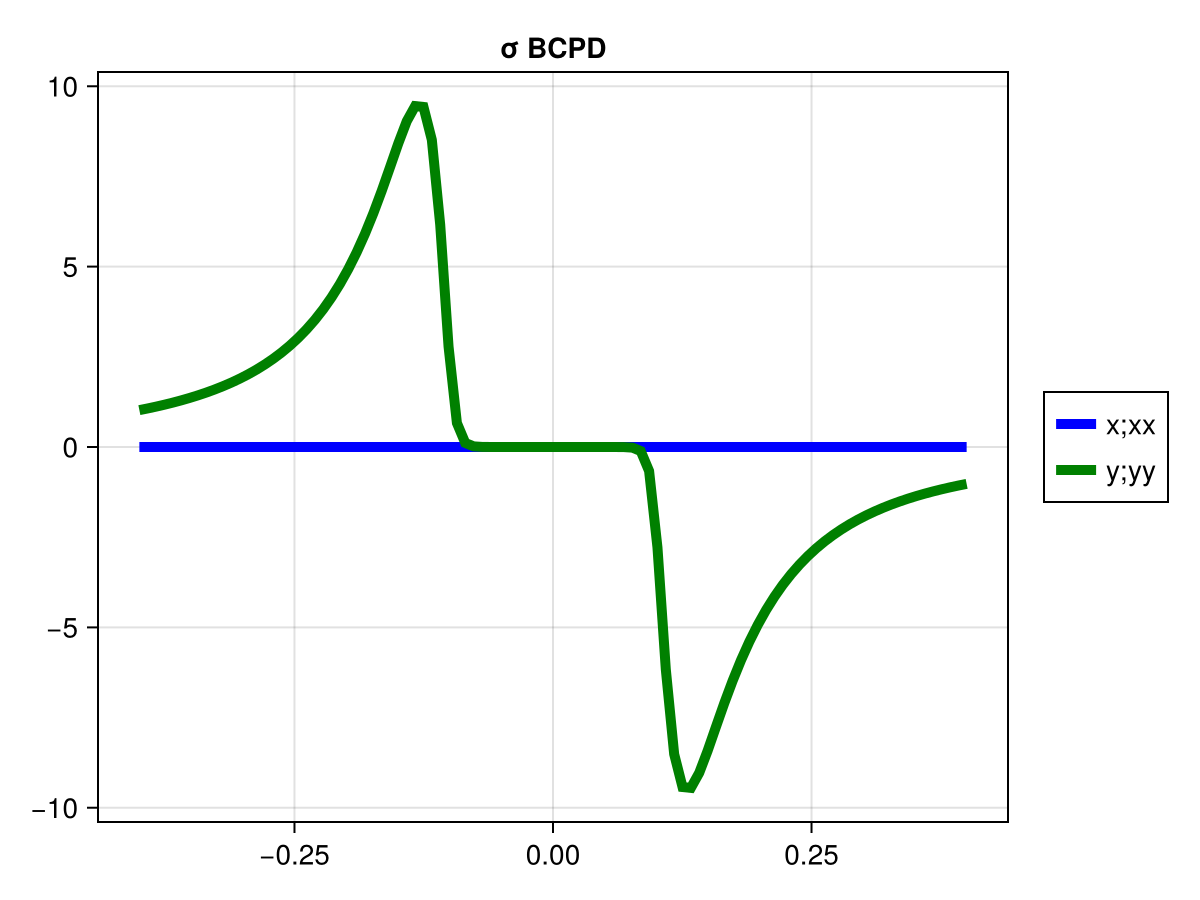

In [39]:
let μmin = -0.4, μmax = 0.4, μnum = 100, lim_k = 0.5, nps = 500, νt = 0.1, Δ = 0.1, TKelv = 50.0
    # Chemical Potential 
    μvals::Vector{Float64} = LinRange(μmin, μmax, μnum)

    # Main computation 
    res1 = σ_BCPD(νt = νt, Δ = Δ, a = 1, b = 1, c = 1, TKelv = TKelv, lim_k = lim_k, nps = nps, μmin = μmin, μmax = μmax, μnum = μnum)
    res2 = σ_BCPD(νt = νt, Δ = Δ, a = 2, b = 2, c = 2, TKelv = TKelv, lim_k = lim_k, nps = nps, μmin = μmin, μmax = μmax, μnum = μnum)

    # Plotting 
    f = Figure()
    ax = Axis(f[1, 1], title = "σ BCPD")
    m1 = lines!(ax, μvals, res1, linewidth = 5.0, color = :blue)
    m2 = lines!(ax, μvals, res2, linewidth = 5.0, color = :green)
    legend = Legend(f, [m1, m2], ["x;xx", "y;yy"])
    f[1, 2] = legend
    f
end

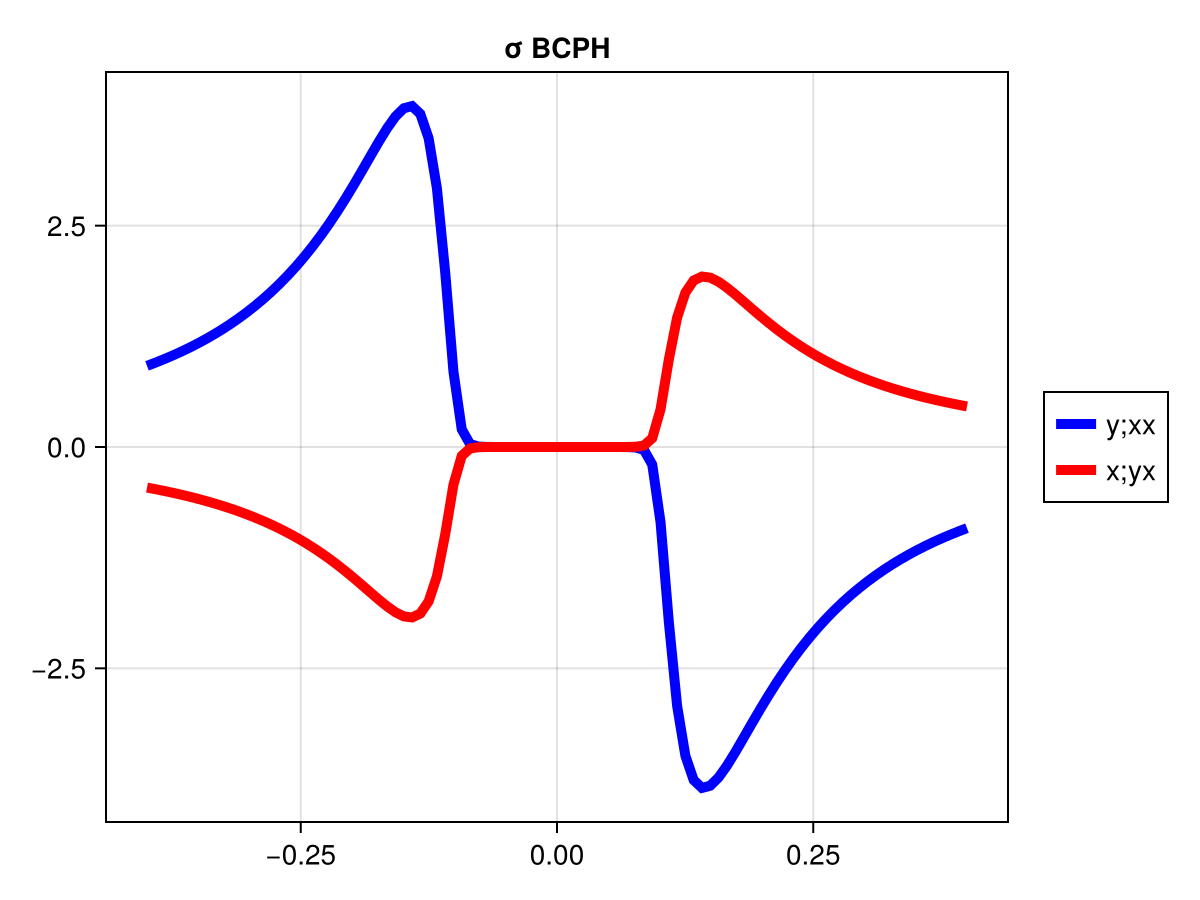

In [40]:
let μmin = -0.4, μmax = 0.4, μnum = 100, lim_k = 0.5, nps = 500, νt = 0.1, Δ = 0.1, TKelv = 50.0
    # Chemical Potential 
    μvals::Vector{Float64} = LinRange(μmin, μmax, μnum)

    # Main computation 
    res1 = σ_BCPH(νt = νt, Δ = Δ, a = 2, b = 1, c = 1, TKelv = TKelv, lim_k = lim_k, nps = nps, μmin = μmin, μmax = μmax, μnum = μnum)
    res2 = σ_BCPH(νt = νt, Δ = Δ, a = 1, b = 2, c = 1, TKelv = TKelv, lim_k = lim_k, nps = nps, μmin = μmin, μmax = μmax, μnum = μnum)

    # Plotting 
    f = Figure()
    ax = Axis(f[1, 1], title = "σ BCPH")
    m1 = lines!(ax, μvals, res1, linewidth = 5.0, color = :blue)
    m2 = lines!(ax, μvals, res2, linewidth = 5.0, color = :red)
    legend = Legend(f, [m1, m2], ["y;xx", "x;yx"])
    f[1, 2] = legend
    f
end